# **15장 – RNN과 CNN을 사용해 시퀀스 처리하기**
> 우리는 늘 미래를 예측하며 살고 있습니다. 이장에서는 미래를 예측할 수 있는 네트워크인 순환신경망(Recurrent Neural Network)를 알아봅니다.
- RNN의 기본적인 개념을 살펴보고 역전파하여 네트워크를 훈련하는 방법을 살펴봅니다
    
- ARMA,모델을 살펴보고 RNN을 비교합니다.
- 제한적인 단기기억은 LSTM과 GRU를 통해 확장하는 것도 배워봅니다.
- RNN이 순차데이터를 다룰수 있는 유일한 신경망은 아님. 작은 시퀀스는 FCN이 처리가능하고, 오디오/텍스트처럼 매우긴 시퀀스는 CNN도 작동하므로, 이 두가능성을 살펴본 뒤 waveNet (수만개의 타임스텝을 가진 시퀀스 다룰수있는CNN)도 구현

## 설정

이 프로젝트에는 Python 3.7 이상이 필요합니다:

In [1]:
import sys

assert sys.version_info >= (3, 7)

그리고 TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-10-27 00:43:40.044186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1729989820.056944     284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1729989820.060931     284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 00:43:40.074614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


이전 챕터에서 했던 것처럼 기본 글꼴 크기를 정의하여 그림을 더 예쁘게 만들어 보겠습니다:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

그리고 `images/rnn` 폴더를 만들고(아직 존재하지 않는 경우), 이 노트북을 통해 책에 사용할 그림을 고해상도로 저장하는 데 사용되는 `save_fig()` 함수를 정의해 보겠습니다:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

이 챕터는 GPU가 없으면 매우 느려질 수 있으므로 GPU가 있는지 확인하거나 그렇지 않으면 경고를 표시합니다:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.")
    if "google.colab" in sys.modules:
        print("런타임 > 런타임 유형 변경으로 이동하여 GPU를 선택하세요.")

GPU가 감지되지 않았습니다. 신경망은 GPU가 없으면 매우 느릴 수 있습니다.


W0000 00:00:1729989825.718161     284 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## RNN 이론의 이해
- 지금까지는 활성화신호가 입력층에서 출력층 방향으로 흐르는 피트포워드 신경망에 초점 맞췄다면,<br> RNN은 비슷하면서도 뒤쪽으로 순환하는 연결도 있음

<img src="https://drive.google.com/uc?id=1CzpTXD8oHVJ4KeNG3ahQ4uGG9EuT_G7y" width="600" height="200">

> 순환뉴런(왼쪽) 과 타임스텝으로 펼친모습

- 순환뉴런으로 이뤄진 층은 쉽게 만들수 있음, 타임스텝t 마다 모든 뉴런은 입력벡터 $x_{(t)}$와 이전타임스텝의 출력벡터 $\hat y_{(t-1)}$을 받음 : 입력과 출력 모두 벡터
<br>
<img src="https://drive.google.com/uc?id=16YpSLghsx4dnMFqtQuKlUuJfjXlKU5Kk" width="600" height="200">

- 각 순환뉴런은 두벌의 가중치 행렬(w) 를 가짐
  - 하나는 입력 $x_{(t)}$를 위한 것 : $w_{x}$
  - 다른 하나는 이전 타임스텝의 출력 $\hat y_{(t-1)}$를 위한 것 : $w_{\hat y}$
  - $\phi$는 Relu와 같은 활성화함수임, b는 편향
- 하나의 순환층의 출력벡터의 수식은 다음과 같음
<br>
<img src="https://drive.google.com/uc?id=1kL-aWz-Pl838evgjHUbBhQD0khSFzErv" width="330" height="80">



- 피드포워드 신경망 처럼 타임스텝  t에서의 모든입력을 행렬X로 만들어서 미니배치 전체에 대해 순환 층의 출력을 한번에 계산할수 있음
<br>
<img src="https://drive.google.com/uc?id=1qV3v_7q7XKwe_oh61cTlZ2Q2d6mhUVlR" width="400" height="150">


- 타임스텝 t에서 순환뉴런의 출력은 이전타임스텝에서 모든 입력에 대한 함수이므로 일종의 메모리 셀 형태로 (간단히 셀), 셀의 상태는 $h_{(t)}$=$f(x_{(t)},h_{(t-1)})$<br>
<img src="https://drive.google.com/uc?id=1qSV_B4ZF0SDyVN6lxHIDEHYxWu421lQC" width="500" height="200">

- RNN은 입력시퀀스를 받아 출력시퀀스를 만들수 있음 : **시퀀스 투 시퀀스 네트워크**
- 또는 입력시퀀스를 네트워크에 주입하고 마지막을 제외한 모든 출력을 무시할 수 있음 : **시퀀스 투 벡터 네트워크**
- 반대로 타임스텝에서 하나의 입력벡터를 반복해서 네트워크에 주입하고 하나의 시퀀스를 출력할 수 있음. **벡터 투 시퀀스 네트워크**
- 마지막으로 인코더라 불리는 시퀀스 투 벡터 네트워크 뒤에 디코더라 불리는 벡터 투 시퀀스 네트워크를 연결할 수 있음
<br>
<img src="https://drive.google.com/uc?id=1nRfPY9fcReoPiPyfdaNNg0npFkrtkb0i" width="500" height="300">

- RNN을 훈련하기 위한 기법은 타임스텝으로 네트워크를 펼치고 역전파 활용 : BPTT(backproPagationThroughTime)
<img src="https://drive.google.com/uc?id=1QA8LKrDW4LngcuJ2pGo99rp6XtIU4DaY" width="500" height="300">



## 시계열의 이해

좋습니다. 우리는 시카고 교통국에 데이터 과학자로 방금 채용되었습니다. 첫번째 일은 내일 버스와 열차에 탑승할 승객수를 예측하는 모델을 만드는 것입니다.



> `ageron/data` 저장소트에서 승객 데이터를 다운로드해 보겠습니다. 원래는 시카고 교통국에서 제공한 것으로, [시카고 데이터 포털](https://homl.info/ridership)에서 다운로드할 수 있습니다.

In [6]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership_extracted'

In [7]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # 더 짧은 이름
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # total은 단순히 bus + rail 이므로 삭제합니다.
df = df.drop_duplicates()  # 중복된 월 제거 (2011-10와 2014-07)

In [8]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


> 2001년 1월 1일에 297,192명이 시카고 버스를 이용했고, 126,455명이 열차를 이용했음.
> daytype은 평일 w, 토요일a, 일요일/공휴일u

2019년의 첫 몇 달을 살펴봅시다(판다스에서는 범위의 경계를 포함합니다):

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: F

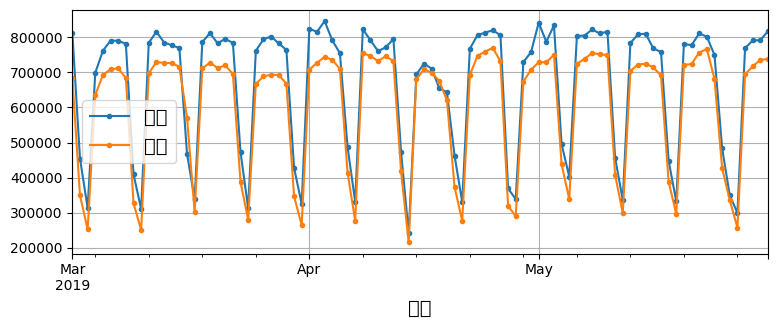

In [9]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.legend(["버스", "열차"]);
plt.xlabel("날짜")
save_fig("daily_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

- 타임스텝마다 여러개의 값이 있으므로 다변량 시계열 vs 버스 하나만 본다면 단변량시계열.
- 시계열의 가장 일반적 작업은 미래의 값을 예측하는 것.
- 다른작업은 imputation(결측치채우기), 분류, 이상치 탐지 등이 있음.
- 비슷한 패턴이 반복되는 것을 계절성이라고 함. 패턴이 강력하면 예측성 좋음~ naive forecasting가능
- 단순 예측을 시각화 하기 위해 주기만큼의 지연된 시계열을 빼주는 것을 차분이라고 함.
> 그럼 주기성에 맞게 전의 선도 그리고, 차분을 그려보자

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: F

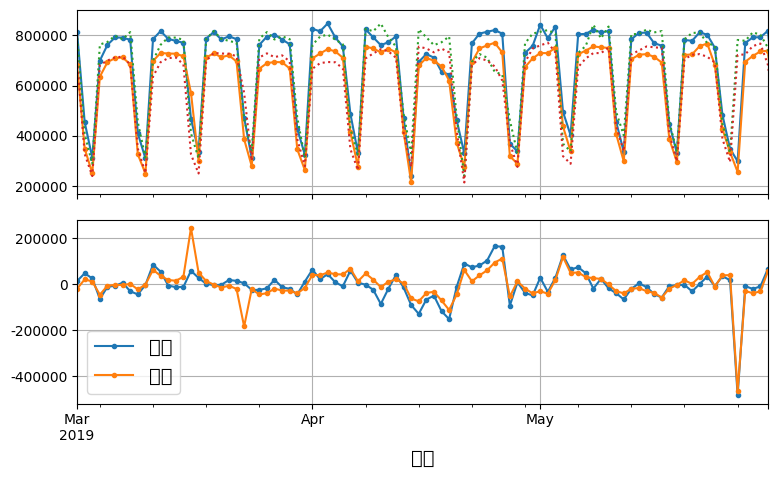

In [10]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # 원본 시계열
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 지연시계열을 점선으로 그리기
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7일 차분 시계열
axs[1].legend(["버스", "열차"])
axs[1].set_xlabel("날짜")
axs[0].set_ylim([170_000, 900_000])  # 추가 코드 - 그래프를 아름답게 꾸미기
save_fig("differencing_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

- 와~ 지연된 시계열이 실제 시계열을 잘 따라가고 있음. 시계열이 지연된 자기자신과 상관관계를 가질 때 자기상관(autocorrelation) 시계열이라고 함. 5월말을 제외하면 차이가 작음. 5월말엔 무슨일이 있었을까?

In [11]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

- 메모리얼데이 휴일이어서 주말이 길었음. 이 열을 사용해 예측을 개선할수 있지만 MAE를 구하여 아이디어를 얻어보자

평균 절대 오차(MAE)는 평균 절대 편차(MAD)라고도 합니다:

In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

3~5월의 평균절대값오차는 버스 43915명, 기차 41143명 수준임. 이게 많이나는 건지 알수 있나? 상대비교를 해야지...

평균 절대 비율 오류(MAPE):

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

그래서 모수로 나눴더니 기차의 비율오류가 더 큰것을 알수 있음

이제 연도별 계절성과 장기 트렌드를 살펴보겠습니다:
- 장기간 트랜드를 확인하기 위해 각 시계열의 12개월 이동 평균도 함께 구함

/tmp/ipykernel_284/2125188364.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean(numeric_only=True)  # 월별 평균을 계산합니다.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_284/2587958765.py:9: Use

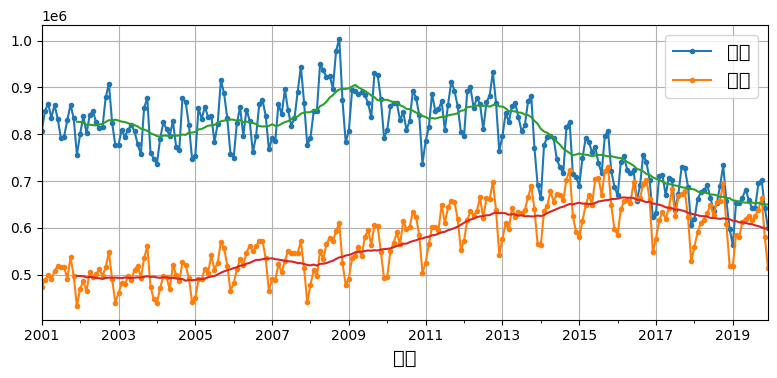

In [14]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean(numeric_only=True)  # 월별 평균을 계산합니다.
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
ax.legend(["버스", "열차"]);
ax.set_xlabel('날짜')
save_fig("long_term_ridership_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

- 12개월의 차분도 그려서 자기상관성을 확인한다.
  - 열차가 버스보다 자기 상관성이 큰것을 볼수 있음

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_284/2587958765.py:9: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: F

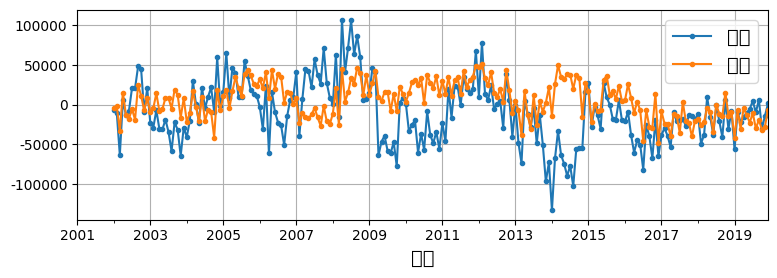

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.legend(["버스", "열차"])
plt.xlabel("날짜")
save_fig("yearly_diff_plot")  # 추가 코드 - 책의 그림을 저장합니다.
plt.show()

- 차분은 연간 계절성을 제거할 뿐만아니라 장기간 트랜드도 없앰.
  - 계절성이나 트랜드를 없애는 대표적인 기법임 -> 통계적 속성이 일정한 정상 시계열을 분석하는 것이 더 쉬워짐
> 계절성, 트랜드, 차분, 이동평균의 개념

## ARMA분석
- 자기회귀이동평균(AutoRegressionMovingAverage) : 지연된 값의 간단한 가중치 합을 사용하여 예측을 구하고 이동 평균을 더해서 예측을 수정함
<img src="https://drive.google.com/uc?id=13hSk2zEefQvSrMkSm1ZVA52zFhEk1gs3" width="300" height="100">



## ARIMA 분석
- 자기회귀누적이동평균 (AutoRegressionIntergratedMovingAverage)로 d번의 차분을 수행해 시계열을 정상으로 만들고 일반적 ARMA모델을 적용하여 예측한다음 차분으로 뺐던 값을 다시 더함


- Seasonal을 더한 SARIMA모델로 발전, 계절항을 추가로 모델링하여 7개의 하이퍼파라미터를 가짐
> 열차시계열에 SARIMA모델을 적용해서 내일의 승객수를 예측해보자.

Colab에서 실행하는 경우 `statsmodels` 라이브러리를 설치합니다:

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [17]:
'''
sarima로 예측해보자
'''
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D") # 2019년 5월 말까지의 승객데이터 빈도를 일자별로설정
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # 427,758.6 반환

In [18]:
y_pred[0]  # ARIMA 예측

/tmp/ipykernel_284/3717318111.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA 예측


np.float64(427758.62641035335)

In [19]:
df["rail"].loc["2019-06-01"]  # 타깃 값

np.int64(379044)

In [20]:
df["rail"].loc["2019-05-25"]  # 단순 예측(1주일 전의 값)

np.int64(426932)

In [21]:
import warnings
warnings.filterwarnings('ignore')

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1): # 하루를 차분해줌
    model = ARIMA(rail_series[origin:today],  # "오늘"까지의 데이터로 훈련
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # 매일 모델을 재훈련한다는 점에 유의하세요!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # 32,040.7 반환

In [22]:
mae

np.float64(32040.720089453378)

> MAE가 단순예측보다 크게 낮음.

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

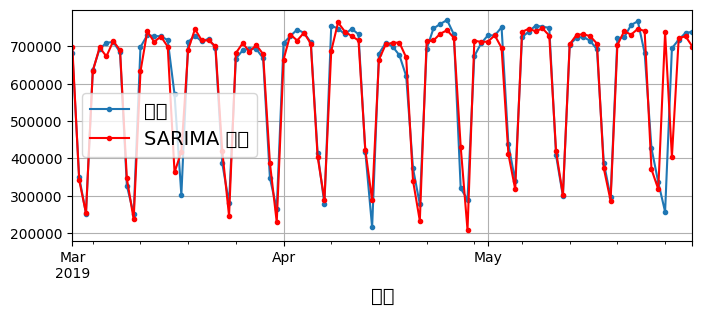

In [23]:
# 추가 코드 - SARIMA 예측을 표시합니다.
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="실제", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA 예측")
ax.set_xlabel("날짜")
plt.legend()
plt.show()

추가 코드 - 자기 상관관계 함수(ACF) 및 부분 자기 상관관계 함수(PACF)를 그리는 방법을 보여줍니다.
[참고자료](https://homl.info/arimatuning)

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

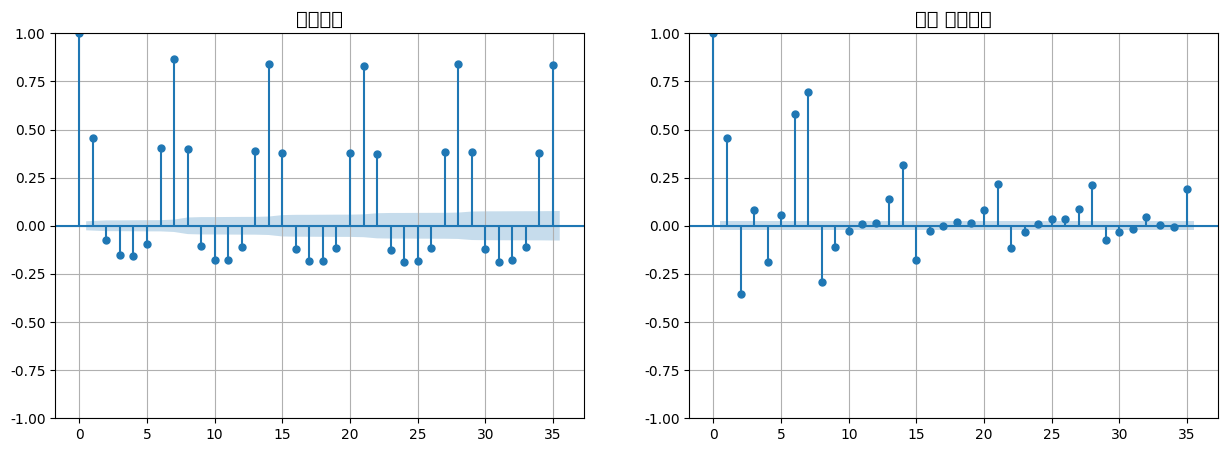

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35, title="자기상관")
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm",
          title="부분 자기상관")
axs[1].grid()
plt.show()

## 기본 선형모델을 통한 예측
- 과거 8주(56일)의 데이터를 기반으로 내일의 승객수 예측
  - 입력 : 각 시퀀스는 56개의 값을 윈도우로 하고, 타겟값은 그 다음값

### 텐서프로로 데이터셋 구성하기

In [26]:
'''
연습 : 0~5를 담은 시계열을 받아서 길이가 3인 window, 배치크기 2인 데이터셋을 만드는 방법
'''
import tensorflow as tf
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # 네번째 원소부터 타겟
    sequence_length=3,
    batch_size=2
)

In [27]:
list(my_dataset)

2024-10-27 00:44:13.862930: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

윈도우사이즈 3인 샘플3개

In [28]:
import tensorflow as tf
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[4:],  # 네번째 원소부터 타겟
    sequence_length=4,
    # batch_size=2
)

In [29]:
'''
Dataset.window() 매서드 사용하여 같은 결과를 얻을수 있음 (리스트의 중첩된 데이터셋을 반환)하기에
셔플링하거나 배치로 묶을 때 유용함
'''
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-10-27 00:44:14.428664: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-27 00:44:14.432122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 00:44:14.439170: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-27 00:44:14.448944: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


> 데이터셋은 6개의 샘플을 담고 있으며, 이전 윈도보다 한스텝씩 앞으로 이동함.

In [30]:
'''
drop_remainder=True를ㄹ 설정하면 작은 윈도우는 삭제할 수 있음.
모델에서는 데이터셋이 아니라, 텐서를 반환하기 때문에 dataset.flat_map()으로
배치를 담아서 구성해줘야함
'''
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [31]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [32]:
'''
마지막으로 map()메서드 사용하여 윈도를 입력과 타겟으로 나눔,
또한 만들어진 윈도를 크기가 2인 배치로 만들수 있음
'''
dataset = to_windows(tf.data.Dataset.range(6), 4) # 4인 배치 만들고
dataset = dataset.map(lambda window: (window[:-1], window[-1])) #입력3개 + 타깃1개로 나눔
list(dataset.batch(2))  # 배치사이즈 2로 묶음

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

### 훈련/검증/테스트 데이터셋 나누기
데이터를 계속 살펴보기 전에 훈련, 검증 및 테스트를 위해 시계열을 세 가지 기간으로 나누어 보겠습니다.

In [33]:
'''
스케일링 조정으로 (0~1사이의 값) 가중치 초기화와 학습률 효율화
'''
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [34]:
'''
회귀모델 만들기 위한 데이터셋을 준비해보자
'''
seq_length = 56
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [35]:
'''
경사하강법을 활용한 단순 신경망을 1개층 활용하여(단순회기) 훈련 / 예측 해보자
'''

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614 - mae: 0.2850 - val_loss: 0.0061 - val_mae: 0.0806
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - mae: 0.1047 - val_loss: 0.0061 - val_mae: 0.0779
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - mae: 0.0871 - val_loss: 0.0052 - val_mae: 0.0692
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0806 - val_loss: 0.0047 - val_mae: 0.0641
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - mae: 0.0823 - val_loss: 0.0051 - val_mae: 0.0709
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - mae: 0.0831 - val_loss: 0.0058 - val_mae: 0.0810
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0768 - val_loss: 0.0042 - val_mae: 0.0596
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - mae: 0.0736 - val_loss: 0.0040 - val_mae: 0.0581
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.005

In [26]:
# 추가 코드 - 모델을 평가합니다.
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0369 


36435.3284239769

SARIMA모델보다는 안좋은 결과를 보임

## 간단한 RNN 사용

In [36]:
'''
keras.layers.SimpleRNN()을 가져와서 예측
'''
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [37]:
# 추가 코드 - 여러 번 재사용할 유틸리티 함수를 정의합니다.

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [38]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0380 - mae: 0.2174 - val_loss: 0.0198 - val_mae: 0.1560
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - mae: 0.1545 - val_loss: 0.0191 - val_mae: 0.1558
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - mae: 0.1555 - val_loss: 0.0185 - val_mae: 0.1538
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - mae: 0.1543 - val_loss: 0.0181 - val_mae: 0.1545
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - mae: 0.1575 - val_loss: 0.0178 - val_mae: 0.1499
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 - mae: 0.1619 - val_loss: 0.0176 - val_mae: 0.1459
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - mae: 0.1602 - val_loss: 0.0173 - val_mae: 0.1461
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - mae: 0.1576 - val_loss: 0.0170 - val_mae: 0.1471
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.01

102782.2270989418

결과가 10만 이상으로 좋지 않음. 이전 모델은 56개의 이전값을 바라봤기에 57개의 파라미터가 있는 반면, RNN 1개의 순환뉴런은 3개의 파라미터만 존재 -> 순환뉴런을 늘려서 파라미터 개수 증가 필요

> 32개의 순환뉴련을 가진 순환층으로 그위에 출력뉴런이 하나이고 활성화 함수가 없는 밀집층을 추가한 모델을 만들어보자.
- 한 타임스텝에서 다음 타임스텝으로 더 많은 정보를 실어나를수 있음

In [39]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # 기본적으로 활성화 함수 없음
])

In [40]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0426 - mae: 0.2269 - val_loss: 0.0042 - val_mae: 0.0717
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - mae: 0.0768 - val_loss: 0.0032 - val_mae: 0.0589
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0612 - val_loss: 0.0022 - val_mae: 0.0401
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - mae: 0.0535 - val_loss: 0.0025 - val_mae: 0.0512
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - mae: 0.0503 - val_loss: 0.0023 - val_mae: 0.0434
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mae: 0.0682 - val_loss: 0.0023 - val_mae: 0.0444
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - mae: 0.0555 - val_loss: 0.0026 - val_mae: 0.0486
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0556 - val_loss: 0.0021 - val_mae: 0.0351
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.00

29399.871826171875

> 파라미터수를 늘리기 위해 32개의 순환뉴런을 만든 결과 MAE가 29665로 SARIMA보다 좋은 결과 보임. 전처리 없이 이런 결과는 의미 있음

## 심층 RNN
- 시계열에 따라 심층으로 회귀전달하며 진행해보는 것 테스트

<img src="https://drive.google.com/uc?id=1QdGYobVLc6_F-HQ9_ofwpHt82uBFkDQz" width="400" height="200">


In [41]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [42]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0202 - mae: 0.1553 - val_loss: 0.0043 - val_mae: 0.0718
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0065 - mae: 0.0827 - val_loss: 0.0032 - val_mae: 0.0595
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0061 - mae: 0.0797 - val_loss: 0.0027 - val_mae: 0.0557
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0046 - mae: 0.0675 - val_loss: 0.0028 - val_mae: 0.0551
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0047 - mae: 0.0653 - val_loss: 0.0021 - val_mae: 0.0430
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - mae: 0.0607 - val_loss: 0.0035 - val_mae: 0.0654
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040 - mae: 0.0605 - val_loss: 0.0020 - val_mae: 0.0410
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - mae: 0.0630 - val_loss: 0.0031 - val_mae: 0.0605
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

29505.720362067223

> 위의 모델과 MAE 큰 차이 없어서 비효율적임. 오히려 다른 변수가 영향을 주는 것을 찾아서 적용하면 좀더 개선할 수 있지 않을까? 그래서 다변량 시계열로 적용해본다

## 다변량 시계열
- 신경망의 큰 장점은 유연성임. 구조를 거의 바꾸지 않고도 다른 변수를 넣어서 시계열을 다룰수 있음.
- 예를 들어서 주말변수, 요일유형을 추가해서 피처로 추가 가능|

In [43]:
df_mulvar = df[["bus", "rail"]] / 1e6  # 버스 및 열차 시계열을 모두 입력으로 사용
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # 내일의 유형을 알고 있습니다.
df_mulvar = pd.get_dummies(df_mulvar,drop_first=True)  # 요일 유형을 원-핫 인코딩합니다.

In [44]:
df_mulvar.head()

,bus,rail,next_day_type_U,next_day_type_W
date,,,,
2001-01-01,0.297192,0.126455,False,True
2001-01-02,0.780827,0.501952,False,True
2001-01-03,0.824923,0.536432,False,True
2001-01-04,0.870021,0.550011,False,True
2001-01-05,0.890426,0.557917,False,False


In [45]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [46]:
import numpy as np

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),  # 4개의 열을 모두 입력으로 사용
    targets=mulvar_train["rail"][seq_length:],  # 열차 시계열만 예측
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [47]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)
])

In [ ]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0867 - mae: 0.3086 - val_loss: 0.0110 - val_mae: 0.1423
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - mae: 0.0744 - val_loss: 0.0013 - val_mae: 0.0402
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mae: 0.0399 - val_loss: 0.0012 - val_mae: 0.0388
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0388 - val_loss: 0.0012 - val_mae: 0.0379
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0378 - val_loss: 9.2185e-04 - val_mae: 0.0322
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0344 - val_loss: 0.0018 - val_mae: 0.0514
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0364 - val_loss: 8.0468e-04 - val_mae: 0.0285
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mae: 0.0350 - val_loss: 8.7320e-04 - val_mae: 0.0294
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

> 심층RNN보다도 훨씬 개선된 것을 볼수 있음. 이번에는 버스와 열차를 모두 예측하는 RNN모델을 구현해보자. 이번에는 타깃이 2개가 구성이 된다. 주의할 것은 출력층이 1이 아니라 2가 되어야 된다는 것

In [ ]:
# 추가 코드 - 버스와 열차를 모두 예측하는 멀티태스크 RNN 구축 및 훈련

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 타깃 2개
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

In [ ]:
# 추가 코드 - 버스에 대한 순진한 예측을 평가합니다.
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

In [ ]:
# 추가 코드 - 버스와 열차 모두에 대한 멀티태스크 RNN의 예측을 평가합니다.
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    # mae = 1e6 * tf.keras.metrics.mean_absolute_error(
    #     mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    mae = (mulvar_valid[name][seq_length:] - Y_preds_valid[:, idx]).abs().mean() * 1e6

    print(name, int(mae))

## 여러 스텝 앞을 예측하기
- 지금까지 하나의 타임스텝의 값만 예측했지만, 다수의 값도 예측 가능.

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

In [ ]:
# 추가 코드 - 그림 15-11 생성 및 저장

# 예측은 2019년 57일째인 2019-02-26에 시작하여 2019-03-11에 종료됩니다. 총 14일입니다.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="진짜", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="예측", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="오늘")
ax.set_ylim([200_000, 800_000])
ax.set_xlabel("날짜")
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

이제 14개의 다음 값을 한 번에 모두 예측하는 RNN을 만들어 보겠습니다:

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(np.float32),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [ ]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14) # 14일을 예측하므로 14개의 출력층 생성
])

In [ ]:
# 추가 코드 - 이전과 같이 모델을 컴파일, 훈련 및 평가합니다.
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

In [ ]:
X = mulvar_valid.to_numpy(np.float32)[np.newaxis, :seq_length]  # 크기 [1, 56, 5]
Y_pred = ahead_model.predict(X)  # 크기 [1, 14]

이제 각 타임 스텝에서 다음 14스텝을 예측하는 RNN을 만들어 보겠습니다. 즉, 타임 스텝 0\~55를 기준으로 타임 스텝 56\~69를 예측하는 대신 타임 스텝 0에서 타임 스텝 1\~14를 예측하고, 타임 스텝 1에서 타임 스텝 2\~15를 예측하는 식으로 예측하고, 마지막 타임 스텝에서 타임 스텝 56\~69를 예측합니다. 이 모델은 코잘(causal) 모델이므로 어떤 타임 스텝에서든 예측을 할 때는 과거의 타임 스텝만 볼 수 있습니다.

데이터셋을 준비하기 위해 `to_windows()`를 두 번 사용하여 다음과 같이 연속된 윈도의 시퀀스를 가져올 수 있습니다:

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

그런 다음 원소를 원하는 입력과 타깃으로 분할할 수 있습니다:

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

이 아이디어를 유틸리티 함수로 만들어 봅시다. 이 함수는 셔플(선택 사항)과 배치 처리도 담당합니다:

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(
        series.to_numpy(np.float32)), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

이전과 거의 동일하나 return_sqquences=True를 설정하여, 벡터의 시퀀스를 출력함. 매 타임스텝에 적용됨. 사실 동일한 결과를 얻는 다른 방법은 커널크기가 1인 Conv1D층을 사용하는 것

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))나
    # tf.keras.layers.Conv1D(14, kernel_size=1) 와 동일합니다
])

In [ ]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

In [ ]:
X = mulvar_valid.to_numpy(np.float32)[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # 마지막 타임 스텝의 출력만

In [ ]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

단순한 RNN은 시계열을 예측하거나 다른 종류의 시퀀스를 처리하는데 매우 뛰어남. 하지만 긴 시계열이나 시퀀스에서는 성능이 좋지 않음

# 층 정규화를 사용한 심층 RNN

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization() # 층 정규화를 넣어줌
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

# 추가 자료 - 사용자 정의 RNN 클래스 만들기

RNN 클래스는 마법이 아닙니다. 사실, 자신만의 RNN 클래스를 구현하는 것은 그리 어렵지 않습니다:

In [ ]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # self.cell에 get_initial_state() 메서드가 없는 경우 0으로 돌아갑니다.
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # 출력을 [time steps, batch size, dims] 크기의 배열로 쌓습니다.
            # 그다음 전치하여 [batch size, time steps, dims] 크기로 만듭니다.
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

`@tf.function`은 `for` 루프 전에 `output` 변수를 생성해야 하므로, 해당 값을 전혀 사용하지 않더라도 그 값을 0 텐서로 초기화합니다. 함수가 그래프로 변환되면 이 사용되지 않은 값은 그래프에서 잘려나가므로 성능에 영향을 미치지 않습니다. 마찬가지로 `@tf.function`은 `self.return_sequences`가 `False`인 경우에도 `sequences` 변수가 사용되는 `if` 문 앞에 생성되어야 하므로, 이 경우에는 0 크기의 `TensorArray`를 생성합니다.

In [ ]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다)

In [ ]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=500)

# LSTM
- RNN을 거치며 데이터가 변환되므로 길어지게 되면 데이터가 소실되는 문제가 발생함. 이런 문제를 해결하기 위해 LSTM 등장
- 장기기억을 위한 c를 받고 삭제게이트는 삭제한 내용 제어 c는 기억을 일부 잃고, 입력게이트로 다시 기억을 추가함 (탄젠트함수에 전달되어 y에 영향)
  - 입력게이트는 기억을 추가함에 있어서 어느부분이 더해져야하는지 제어
- (단기상태h가 추가로 만들어지고) 출력게이트는 y와 h 중 출력해야하는 것을 제어

<img src="https://drive.google.com/uc?id=1JYnJ9O_ZBbp_pEWfrUdQxKUXNrVEl91O" width="400" height="200">


In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

# GRU
- 보다 단순하게 인코더- 디코더 네트워크로 효율화
  - 하나의 게이트제어기 z가 삭제/입력을 모두 제어,
  - 출력게이트는 없이, 모든 상태벡터가 매타임스텝마다 출력
  - 이전상태의 어느부분의 주 층(g)에 노출될지 제어하는 새로운 게이트제어기 r 존재

<img src="https://drive.google.com/uc?id=1ApngnaaE373qIg2K-S8-QotJHeo5gm1d" width="400" height="200">


In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

## 1D 합성곱 층으로 시퀀스 다루기
- 14장에서 2D합성곱이 이미지에서 슬라이딩 하여 특성맵 생성하는 것 보았음.
- 합성곱 층으로 시퀀스 길이를 줄이면 GRU 층이 더 긴 패턴을 감지하는데 도움이 됨

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=500)

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [ ]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

# 추가 자료 – Wavenet 구현

- 2016년 딥마인드 연구자들이 소개한 구조
- 층마다 팽창비율을 두배로 늘리는 합성곱 층을 쌓고, 각 합성곱 층이 한번에 2개의 타임스텝만 바라보고, 다음층은 4개의 타임스텝을 보는 방식으로, 확장.
- 팽창 비율을 두배로 늘린 덕분에 네트워크는 아주 긴 시퀀스를 효율적으로 처리할 수 있음
<br>
<img src="https://drive.google.com/uc?id=1Z1JgBSXUDnNcf33Ojo2peGFAZTZPMv1o" >


다음은 논문에 정의된 WaveNet 구현입니다. ReLU와 파라미터를 가진 스킵 연결 대신 게이트 활성화 유닛(Gated Activation Unit)을 사용하며, 시퀀스가 점점 짧아지는 것을 방지하기 위해 왼쪽에 0으로 패딩합니다:

In [ ]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [ ]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 논문에서는 10
n_bloS

5에포크 동안만 훈련하면 효과가 있다는 것을 알 수 있습니다(원하는 경우 더 늘릴 수 있습니다):

In [ ]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

이 장에서는 RNN의 기초를 살펴보고 이를 사용하여 시퀀스(즉, 시계열)를 처리하는 방법을 살펴보았습니다. 이 과정에서 CNN을 포함한 시퀀스를 처리하는 다른 방법도 살펴봤습니다. 다음 장에서는 자연어 처리를 위해 RNN을 사용하고, RNN에 대해 자세히 알아볼 것입니다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션 기반 인코더-디코더). 또한 어텐션 전용 아키텍처인 트랜스포머에 대해서도 살펴볼 것입니다.

# 연습문제

## 1. to 8.

부록 A 참조.

## 9. SketchRNN 데이터셋 다루기

_연습문제: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해보세요._

이 데이터셋은 아직 TFDS에서 제공하지 않습니다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중입니다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해보죠(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸립니다):

In [ ]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

In [ ]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [ ]:
train_files

In [ ]:
eval_files

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
sorted(class_names)

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

In [ ]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

대부분의 스케치는 100개 포인트 이하로 구성되어 있습니다:

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("길이")
plt.ylabel("밀도")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

In [ ]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

In [ ]:
model.save("my_sketchrnn", save_format="tf")

## 10. 바흐 합창곡

_연습문제: [바흐 합창곡](https://homl.info/bach) 데이터셋을 다운로드하여 압축을 풉니다. 이 데이터셋은 요한 제바스티안 바흐가 작곡한 382개의 합창곡으로 구성되어 있습니다. 각 곡은 100에서 640까지 타임 스텝 길이입니다. 각 타임 스텝은 4개의 정수를 담고 있습니다. 각 정수는 피아노 음표의 인덱스에 해당합니다(연주되는 음표가 없다는 것을 의미하는 0은 제외). 코랄의 타임 스텝 시퀀스가 주어지면 다음 타임 스텝(4개의 음표)을 예측할 수 있는 순환 모델, 합성곱 모델 또는 두 가지를 합친 모델을 훈련하세요. 그 다음 이 모델을 사용해 한 번에 하나의 음표씩 바흐와 같은 음악을 생성하세요. 코랄의 시작 부분을 모델에 주입하고 다음 타임 스텝을 예측합니다. 이 타임 스텝을 입력 시퀀스에 추가하여 모델이 다음 음표를 예측하게 만드는 식입니다. 또 바흐를 위한 [구글 두들](https://www.google.com/doodles/celebrating-johann-sebastian-bach)에 사용한 구글의 [Coconet 모델](https://homl.info/coconet)을 확인해보세요._

In [ ]:
tf.keras.utils.get_file(
    "jsb_chorales.tgz",
    "https://github.com/ageron/data/raw/main/jsb_chorales.tgz",
    cache_dir=".",
    extract=True)

In [ ]:
jsb_chorales_dir = Path("datasets/jsb_chorales")
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [ ]:
import pandas as pd

def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [ ]:
train_chorales[0]

음표의 범위는 36(C1 = 옥타브 1의 C)에서 81(A5 = 옥타브 5의 A)까지이고 무음을 위해 0을 추가합니다:

In [ ]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

이 코랄을 듣기 위한 몇 개의 함수를 만들어 보죠(자세한 내용을 이해할 필요는 없습니다. 사실 MIDI 플레이어처럼 더 간단한 방법이 있지만 그냥 하나의 합성기(synthesizer)를 만들어 보고 싶었습니다):

In [ ]:
from IPython.display import Audio

def notes_to_frequencies(notes):
    # 한 옥타브 올라갈 때 주파수는 두배가 됩니다; 옥타브마다 12개의 반음이 있습니다;
    # 옥타브 4의 A는 440Hz이고 음표 번호는 69입니다.
    return 2 ** ((np.array(notes) - 69) / 12) * 440

def frequencies_to_samples(frequencies, tempo, sample_rate):
    note_duration = 60 / tempo # tempo는 분당 박자 수로 측정합니다
    # 매 박자마다 딸깍거리는 소리를 줄이기 위해 주파수를 반올림하여 각 음의 끝에서 샘플을 0에 가깝게 만듭니다.
    frequencies = (note_duration * frequencies).round() / note_duration
    n_samples = int(note_duration * sample_rate)
    time = np.linspace(0, note_duration, n_samples)
    sine_waves = np.sin(2 * np.pi * frequencies.reshape(-1, 1) * time)
    # (음표 0 = 무음을 포함해) 9Hz 이하인 주파수는 모두 삭제합니다
    sine_waves *= (frequencies > 9.).reshape(-1, 1)
    return sine_waves.reshape(-1)

def chords_to_samples(chords, tempo, sample_rate):
    freqs = notes_to_frequencies(chords)
    freqs = np.r_[freqs, freqs[-1:]] # 마지막 음표를 조금 더 길게합니다
    merged = np.mean([frequencies_to_samples(melody, tempo, sample_rate)
                     for melody in freqs.T], axis=0)
    n_fade_out_samples = sample_rate * 60 // tempo # 마지막 음을 희미하게 합니다
    fade_out = np.linspace(1., 0., n_fade_out_samples)**2
    merged[-n_fade_out_samples:] *= fade_out
    return merged

def play_chords(chords, tempo=160, amplitude=0.1, sample_rate=44100, filepath=None):
    samples = amplitude * chords_to_samples(chords, tempo, sample_rate)
    if filepath:
        from scipy.io import wavfile
        samples = (2**15 * samples).astype(np.int16)
        wavfile.write(filepath, sample_rate, samples)
        return display(Audio(filepath))
    else:
        return display(Audio(samples, rate=sample_rate))

이제 몇 개의 코랄을 들어 보죠:

In [ ]:
for index in range(3):
    play_chords(train_chorales[index])

멋지네요! :)

새로운 코랄을 생성하기 위해서는 이전의 화음이 주어졌을 때 다음 화음을 예측할 수 있는 모델을 훈련해야 합니다. 한 번에 4개의 음표를 예측하는 식으로 다음 화음을 예측한다면 잘 어울리지 않는 음표를 얻게 됩니다(믿으세요. 제가 해 보았습니다). 한 번에 하나의 음표를 예측하는 것이 간단하고 더 낫습니다. 따라서 모든 코랄을 전처리하여 각 화음을 아르페지오로 바꾸어야 합니다(즉, 동시에 연주되는 음표가 아니라 음표의 시퀀스). 그다음 이전의 모든 음표가 주어졌을 때 다음 음표를 예측하는 모델을 훈련할 수 있습니다. 시퀀스-투-시퀀스 방식을 사용하겠습니다. 신경망에 한 윈도를 주입하고 한 타임 스텝 미래로 이동한 윈도를 예측합니다.

또한 0에서 46까지 범위를 갖도록 값을 이동시키겠습니다. 여기에서 0은 무음을 나타내고 1에서 46까지는 36(C1)에서 81(A5)까지를 나타냅니다.

128 음표(즉, 32개 화음)의 윈도에서 모델을 훈련하겠습니다.

이 데이터셋은 메모리에 올라갈 수 있기 때문에 파이썬 코드를 사용해 RAM에서 코랄을 전처리할 수 있지만 여기에서는 tf.data를 사용해 전처리하는 방법을 시연하겠습니다(다음 장에서 tf.data를 사용해 윈도를 만드는 과정을 자세히 설명하겠습니다).

In [ ]:
def create_target(batch):
    X = batch[:, :-1]
    Y = batch[:, 1:] # 각 스텝에서 아르페지오에 있는 다음 음표를 예측합니다
    return X, Y

def preprocess(window):
    window = tf.where(window == 0, window, window - min_note + 1) # 값 이동
    return tf.reshape(window, [-1]) # 아르페지오로 변환

def bach_dataset(chorales, batch_size=32, shuffle_buffer_size=None,
                 window_size=32, window_shift=16, cache=True):
    def batch_window(window):
        return window.batch(window_size + 1)

    def to_windows(chorale):
        dataset = tf.data.Dataset.from_tensor_slices(chorale)
        dataset = dataset.window(window_size + 1, window_shift, drop_remainder=True)
        return dataset.flat_map(batch_window)

    chorales = tf.ragged.constant(chorales, ragged_rank=1)
    dataset = tf.data.Dataset.from_tensor_slices(chorales)
    dataset = dataset.flat_map(to_windows).map(preprocess)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(create_target)
    return dataset.prefetch(1)

훈련 세트, 검증 세트, 테스트 세트를 만듭니다:

In [ ]:
train_set = bach_dataset(train_chorales, shuffle_buffer_size=1000)
valid_set = bach_dataset(valid_chorales)
test_set = bach_dataset(test_chorales)

이제 모델을 만듭니다:

* 음표를 실수 값으로 모델에 직접 주입할 수 있지만 좋은 결과를 얻지 못할 것입니다. 음표 간의 관계는 단순하지 않습니다. 예를 들어 C3을 C4로 바꾼다면 두 음표 사이에 반음이 12개(즉 한 옥타브) 떨어져 있음에도 멜로디는 여전히 괜찮게 들립니다. 반대로 C3을 C\#3으로 바꾼다면 바로 다음 음표임에도 화음이 매우 좋지 않습니다. 따라서 `Embedding` 층을 사용해 음표를 작은 벡터 표현으로 바꾸겠습니다(임베딩에 대해서는 16장을 참고하세요). 5-차원 임베딩을 사용하므로 첫 번째 층의 출력은 `[batch_size, window_size, 5]` 크기가 됩니다.
* 그 다음 이 데이터를 4개의 `Conv1D` 층을 쌓고 dilation 비율을 두 배씩 늘린 작은 WeveNet 신경망에 주입합니다. 빠른 수렴을 위해 이 층 다음에 `BatchNormalization` 층을 배치합니다.
* 그다음 하나의 `LSTM` 층이 장기 패턴을 감지합니다.
* 마지막으로 `Dense` 층이 최종 음표 확률을 생성합니다. 타임 스텝과 (무음을 포함해) 가능한 음표 마다 배치에 있는 각 코랄에 대해 하나의 확률을 예측합니다. 따라서 출력 크기는 `[batch_size, window_size, 47]`가 됩니다.

In [ ]:
n_embedding_dims = 5

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    tf.keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

이제 모델을 컴파일하고 훈련할 준비가 되었습니다!

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_set, epochs=20, validation_data=valid_set)

여기서는 하이퍼파라미터 탐색을 많이 수행하지 않았습니다. 자유롭게 이 모델을 사용해 하이퍼파라미터를 탐색하고 최적화해 보세요. 예를 들어 `LSTM` 층을 제거하고 `Conv1D` 층으로 바꿀 수 있습니다. 층의 개수, 학습률, 옵티마이저 등을 실험해 볼 수 있습니다.

검증 세트에 대한 모델의 성능이 만족스럽다면 모델을 저장하고 테스트 세트에서 마지막으로 평가합니다:

In [ ]:
model.save("my_bach_model", save_format="tf")
model.evaluate(test_set)

**노트:** 이 예제에서는 테스트 세트가 진짜로 필요하지 않습니다. 모델이 생성한 음악을 듣는 것이 최종 평가가 되기 때문입니다. 따라서 필요하다면 테스트 세트를 훈련 세트에 넣고 모델을 다시 훈련하여 조금 더 나은 모델을 얻을 수 있습니다.

이제 새로운 코랄을 생성하는 함수를 만들어 보죠. 몇 개의 시드 화음을 주고 이를 (모델이 기대하는 포맷인) 아르페지오로 변환합니다. 그다음 모델을 사용해 다음 음표을 예측합니다. 마지막에 4개씩 음표를 모아서 다시 화음을 만들고 최종 코랄을 반환합니다.

In [ ]:
def generate_chorale(model, seed_chords, length):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note = model.predict(arpegio, verbose=0).argmax(axis=-1)[:1, -1:]
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수를 테스트하려면 시드 화음이 필요합니다. 테스트 코랄 중 하나에 있는 처음 8개의 화음을 사용해 보죠(실제로 이는 4번 반복되는 2개의 화음입니다):

In [ ]:
seed_chords = test_chorales[2][:8]
play_chords(seed_chords, amplitude=0.2)

첫 번째 코랄을 생성할 준비를 마쳤습니다! 56개의 화음을 생성하여 총 64개의 화음, 즉 4 소절(소절마다 4개의 화음인 4/4박으로 가정합니다)을 만들어 보겠습니다:

In [ ]:
new_chorale = generate_chorale(model, seed_chords, 56)
play_chords(new_chorale)

이 방식에는 한가지 단점이 있습니다: 너무 보수적인 경우가 많습니다. 실제로 이 모델은 모험을 하지 않아 항상 가장 높은 확률의 음표를 선택합니다. 이전 음표를 반복하면 충분히 듣기 좋고 가장 덜 위험하기 때문에 이 알고리즘은 마지막 음표를 오래 지속시키는 경향이 있습니다. 상당히 지루합니다. 또한 이 모델을 여러 번 실행하면 항상 같은 멜로디를 생성할 것입니다.

조금 더 신나게 만들어 보죠! 항상 가장 높은 점수의 음표를 선택하는 대신, 예측된 확률을 기반으로 랜덤하게 다음 음표를 선택하겠습니다. 예를 들어, 모델이 75% 확률로 C3를 예측하고 25% 확률로 G3를 예측했다면 이 확률대로 랜덤하게 두 음표 중 하나를 선택하겠습니다. 또한 `temperature` 매개변수를 추가하여 시스템의 온도(즉 대담성)를 제어하겠습니다. 높은 온도는 예측 확률을 비슷하게 만들어 가능성이 높은 음표의 확률을 줄이고 가능성이 낮은 음표의 확률을 높입니다.

In [ ]:
def generate_chorale_v2(model, seed_chords, length, temperature=1):
    arpegio = preprocess(tf.constant(seed_chords, dtype=tf.int64))
    arpegio = tf.reshape(arpegio, [1, -1])
    for chord in range(length):
        for note in range(4):
            next_note_probas = model.predict(arpegio)[0, -1:]
            rescaled_logits = tf.math.log(next_note_probas) / temperature
            next_note = tf.random.categorical(rescaled_logits, num_samples=1)
            arpegio = tf.concat([arpegio, next_note], axis=1)
    arpegio = tf.where(arpegio == 0, arpegio, arpegio + min_note - 1)
    return tf.reshape(arpegio, shape=[-1, 4])

이 함수로 3개의 코랄을 생성해 보겠습니다. 하나는 차갑게, 하나는 중간으로, 하나는 뜨겁게 만듭니다(시드, 길이, 온도를 사용해 자유롭게 실험해 보세요). 다음 코드는 각 코랄을 별개의 파일에 저장합니다. 마음에 드는 음악을 만날 때까지 이 셀을 반복해서 실행할 수 있습니다!

**가장 아름다운 코랄을 트위터 @aureliengeron로 공유해 주시면 정말 감사하겠습니다! :))**

In [ ]:
new_chorale_v2_cold = generate_chorale_v2(model, seed_chords, 56, temperature=0.8)
play_chords(new_chorale_v2_cold, filepath="bach_cold.wav")

In [ ]:
new_chorale_v2_medium = generate_chorale_v2(model, seed_chords, 56, temperature=1.0)
play_chords(new_chorale_v2_medium, filepath="bach_medium.wav")

In [ ]:
new_chorale_v2_hot = generate_chorale_v2(model, seed_chords, 56, temperature=1.5)
play_chords(new_chorale_v2_hot, filepath="bach_hot.wav")

마지막으로 재미있는 실험을 해 볼 수 있습니다: 친구에게 마음에 드는 코랄 몇 개와 진짜 코랄을 보내고 어떤 것이 진짜인지 물어 보세요!

In [ ]:
play_chords(test_chorales[2][:64], filepath="bach_test_4.wav")